**Đề tài:** Nhận dạng chứng cứ cho phân tích cảm xúc dựa trên khía cạnh tiếng Việt. \\
**GVHD:** Nguyễn Lưu Thùy Ngân, Nguyễn Văn Kiệt, Nguyễn Đức Vũ, Lưu Thanh Sơn, Huỳnh Văn Tín, Nguyễn Thành Luân. \\
**Sinh viên thực hiện:** Trần Triệu Vũ, Phạm Đức Thể, Nguyễn Văn Hữu Nghĩa. \\
**Các pre-trained sử dụng:**
- [PhoW2V(syllable-300d)](https://drive.google.com/file/d/1R8lRuZgVtm8GUz2PHtCAQfoaaxwYrQ9o/view?usp=sharing)
- [cc.vi.300.vec](https://drive.google.com/file/d/1RZDd0saERsS_QVA28PU7OZx2NaYHrmlN/view?usp=sharing)
- [wiki.vi.vec](https://drive.google.com/file/d/1GX1LLJ7VEKLkPinjUf9sJXXtr05LVRi1/view?usp=sharing)

# Chuẩn bị dữ liệu

## Check GPU

In [ ]:
!nvidia-smi

Mon Dec 20 07:10:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2396476175891910229
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14367702409544595490
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

## Cài đặt thư viện bổ sung và kết nối drive

In [ ]:
%%capture
!pip install keras-crf
!pip install seqeval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU, Concatenate
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Dropout
from keras.initializers import Constant
from keras_crf import CRFModel
from seqeval.metrics import classification_report
from keras.utils.vis_utils import plot_model

## Load data

In [ ]:
def load_data_and_labels(filename, encoding='utf-8'): 
  sents, labels = [], [] 
  words, tags = [], [] 
  with open(filename, encoding=encoding) as f: 
    for line in f: 
      try: 
        line = line.strip() 
        if line: 
          word, tag = line.split(" ") 
          words.append(word) 
          tags.append(tag) 
        else: 
          sents.append(words) 
          labels.append(tags) 
          words, tags = [], [] 
      except Exception as e: 
        pass
  return sents, labels 

In [ ]:
train_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/aspect/train.txt') 
dev_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/aspect/dev.txt')  
test_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/aspect/test.txt')

## Lấy words và tags

In [ ]:
words = list(set(np.concatenate((np.concatenate(train_set[0]), np.concatenate(dev_set[0])))))
words.append("UNK")
words.append("ENDPAD")
tags = list(set(np.concatenate((np.concatenate(train_set[1]), np.concatenate(dev_set[1])))))

num_words = len(words)
num_tags = len(tags)

## Tạo word2idx và tag2idx

In [ ]:
word2idx = {w:i for i,w in enumerate(words)} 
tag2idx = {t:i for i,t in enumerate(tags)}

## Encoding

In [ ]:
max_len = 100
def encoding(data): 
  X = [[word2idx.get(w, num_words-2) for w in t] for t in data[0]] 
  X = pad_sequences(maxlen = max_len, sequences = X, 
                    padding = "post", value = num_words-1) 

  y = [[tag2idx[w] for w in s] for s in data[1]] 
  y = pad_sequences(maxlen=max_len, sequences=y, 
                    padding="post", value=tag2idx["O"])

  return X, y 
 
x_train, y_train = encoding(train_set) 
x_dev, y_dev = encoding(dev_set) 
x_test, y_test = encoding(test_set) 

# Không dử dụng pre-trained embedding

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
input_word = Input(shape=(max_len,), dtype="float64")

# embedding
emb = Embedding(input_dim=num_words, output_dim=300,
                    input_length=max_len)(input_word)

# model
model = SpatialDropout1D(0.33)(emb)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout = 0.33))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout = 0.33))(model)
model = SpatialDropout1D(0.33)(model)
out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
model = Model(input_word, out)
model = CRFModel(model, num_tags)

# setting and summary
opt = optimizers.Nadam(1e-2)
model.compile(optimizer=opt, metrics=['acc'])
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     3812100     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 200)     320800      ['spatial_dropout1d[0][0]

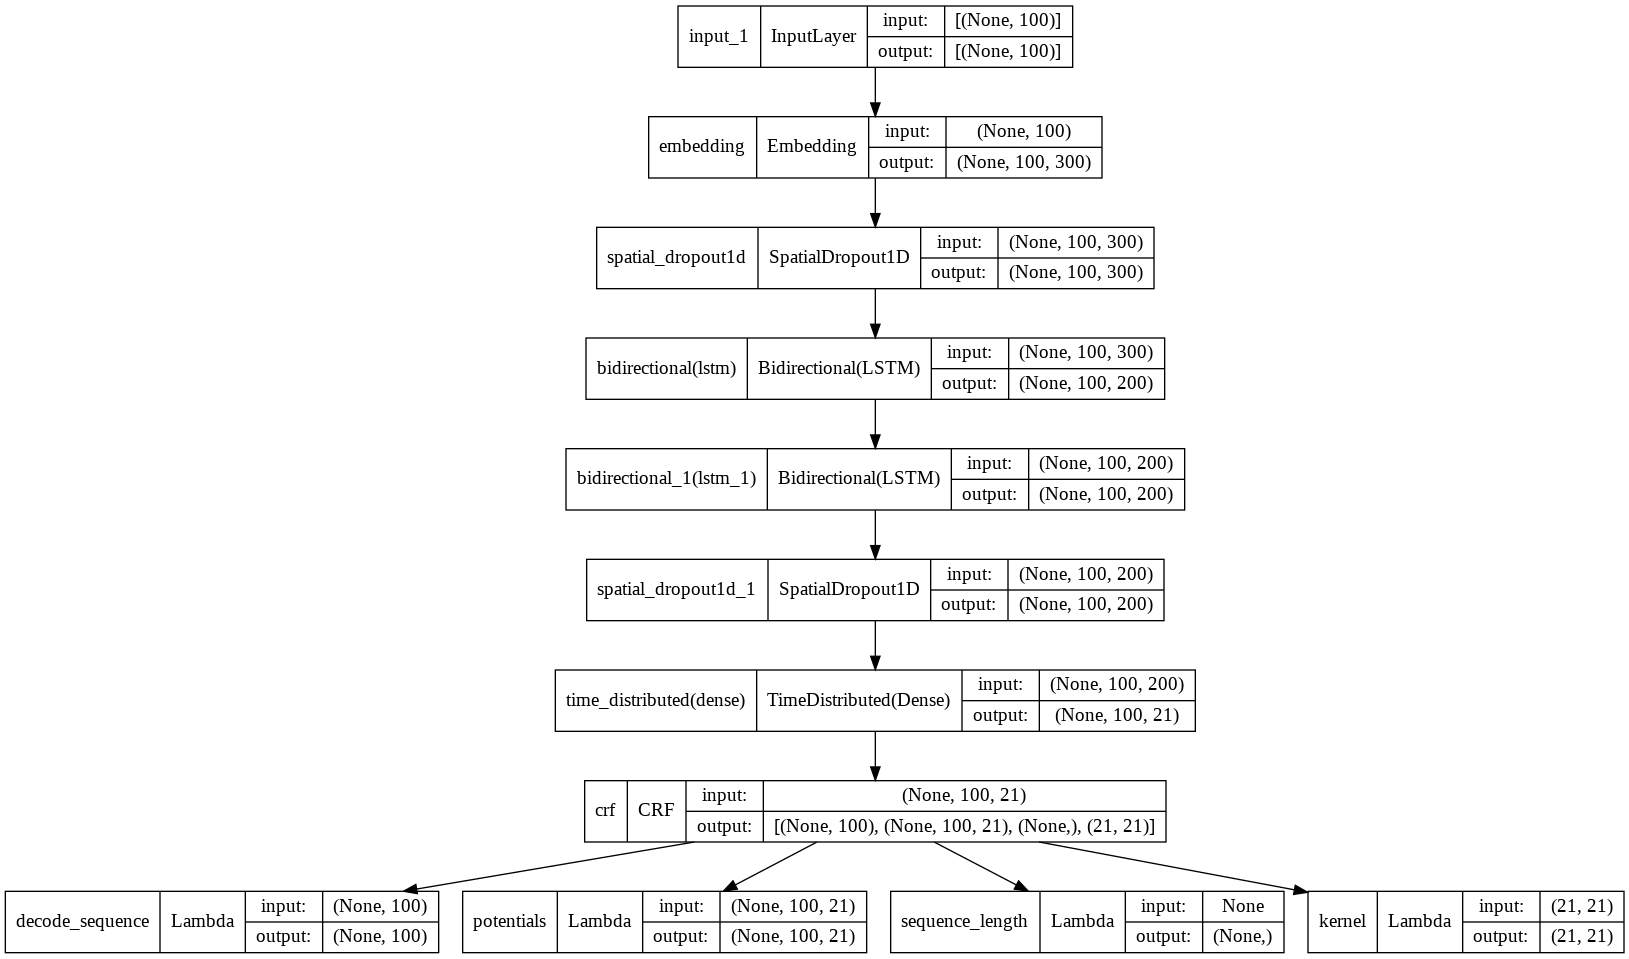

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 20s 296ms/step - decode_sequence_acc: 0.7569 - loss: 99.5759 - val_decode_sequence_acc: 0.7918 - val_loss: 61.8273
Epoch 2/30
30/30 [==============================] - 7s 222ms/step - decode_sequence_acc: 0.8026 - loss: 54.8171 - val_decode_sequence_acc: 0.8316 - val_loss: 38.8003
Epoch 3/30
30/30 [==============================] - 7s 225ms/step - decode_sequence_acc: 0.8519 - loss: 32.2348 - val_decode_sequence_acc: 0.8557 - val_loss: 28.1244
Epoch 4/30
30/30 [==============================] - 7s 226ms/step - decode_sequence_acc: 0.8740 - loss: 22.6755 - val_decode_sequence_acc: 0.8597 - val_loss: 23.8963
Epoch 5/30
30/30 [==============================] - 7s 227ms/step - decode_sequence_acc: 0.8887 - loss: 17.2647 - val_decode_sequence_acc: 0.8718 - val_loss: 20.0202
Epoch 6/30
30/30 [==============================] - 7s 230ms/step - decode_sequence_acc: 0.8963 - loss: 14.0951 - val_decode_sequence_acc: 0.8704 - val_loss: 19.7061
Epo

## Đánh giá mô hình

In [ ]:
def print_report():
  y_tr = y_test
  y_pr = model.predict(np.array(x_test))
  y_pr = y_pr[0]

  Y_tr = []
  Y_pr = []

  for i, j in zip(range(len(y_tr)), range(len(y_pr))):
    true = []
    pred = []
    for k in range(len(y_tr[i])):
      true.append(tags[y_tr[i][k]])
      pred.append(tags[y_pr[j][k]])
    Y_tr.append(true)
    Y_pr.append(pred)

  print(classification_report(Y_tr, Y_pr, digits =4,))

In [ ]:
print_report()

              precision    recall  f1-score   support

     BATTERY     0.5949    0.6632    0.6272       950
      CAMERA     0.6464    0.7146    0.6788       522
      DESIGN     0.5315    0.6081    0.5672       347
    FEATURES     0.4707    0.4929    0.4815       700
     GENERAL     0.5204    0.6069    0.5603      1427
 PERFORMANCE     0.4877    0.5389    0.5121      1182
       PRICE     0.3333    0.2978    0.3146       225
      SCREEN     0.4821    0.5844    0.5284       231
     SER&ACC     0.4326    0.5122    0.4690       451
     STORAGE     0.4074    0.3438    0.3729        32

   micro avg     0.5173    0.5779    0.5459      6067
   macro avg     0.4907    0.5363    0.5112      6067
weighted avg     0.5159    0.5779    0.5448      6067



In [ ]:
def predict(i):
  y_pred = model.predict(np.array([x_test[i]]))
  y_pred = y_pred[0]
  y_true = y_test[i]
  print("{:20}{:20}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(x_test[i], y_true, y_pred[0]):
      print("{:20}{:20}\t{}".format(words[w], tags[true], tags[pred]))

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	I-FEATURES
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn   

# Sử dụng pre-trained PhoW2V

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/word2vec_vi_syllables_300dims.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix1 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix1[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
def model_BiLSTM_CRF(embedding_matrix):
  input_word = Input(shape=(max_len,), dtype="float64")

  # syllabel embedding
  syl_emb = Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant([embedding_matrix]),
                    input_length=max_len, trainable=True)(input_word)

  # model
  model = SpatialDropout1D(0.33)(syl_emb)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = SpatialDropout1D(0.33)(model)
  out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
  model = Model(input_word, out)
  model = CRFModel(model, num_tags)

  # setting and summary
  opt = optimizers.Nadam(1e-2)
  model.compile(optimizer=opt, metrics=['acc'])
  return model

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix1)
model.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 300)     3812100     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 100, 300)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 100, 200)    320800      ['spatial_dropout1d_2[0

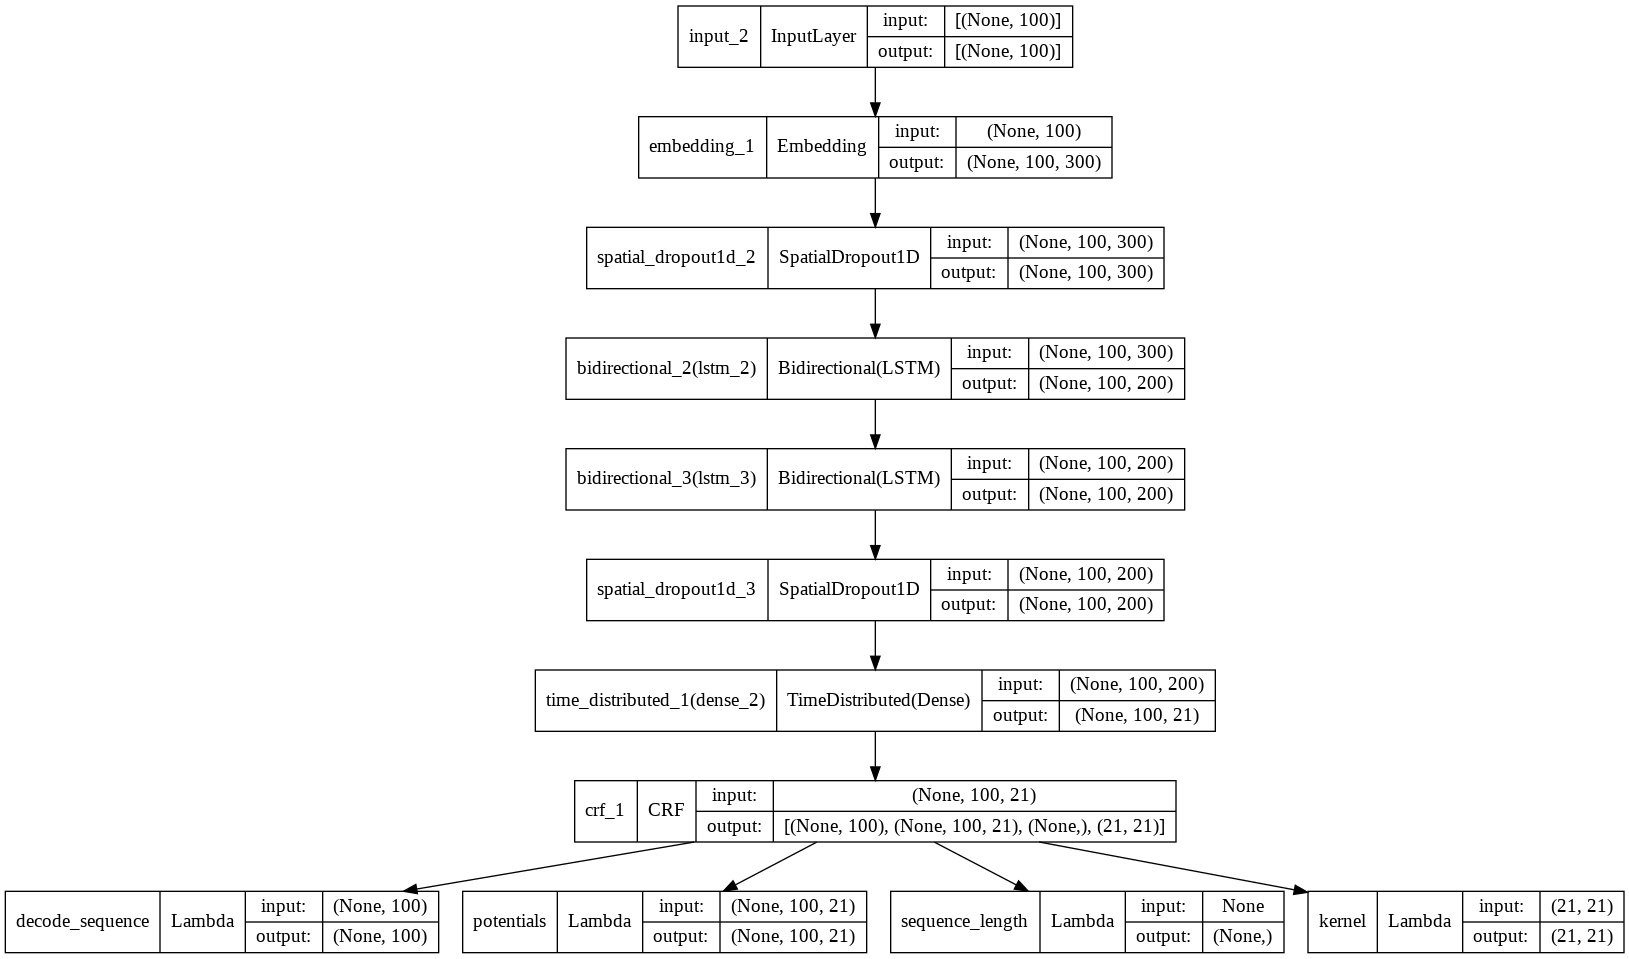

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 17s 293ms/step - decode_sequence_acc: 0.7611 - loss: 97.1825 - val_decode_sequence_acc: 0.7921 - val_loss: 55.4290
Epoch 2/30
30/30 [==============================] - 7s 233ms/step - decode_sequence_acc: 0.7954 - loss: 49.3517 - val_decode_sequence_acc: 0.8100 - val_loss: 35.8930
Epoch 3/30
30/30 [==============================] - 7s 228ms/step - decode_sequence_acc: 0.8374 - loss: 29.9056 - val_decode_sequence_acc: 0.8474 - val_loss: 23.6933
Epoch 4/30
30/30 [==============================] - 7s 236ms/step - decode_sequence_acc: 0.8630 - loss: 20.5409 - val_decode_sequence_acc: 0.8542 - val_loss: 19.1060
Epoch 5/30
30/30 [==============================] - 7s 236ms/step - decode_sequence_acc: 0.8728 - loss: 16.2532 - val_decode_sequence_acc: 0.8642 - val_loss: 16.3270
Epoch 6/30
30/30 [==============================] - 7s 244ms/step - decode_sequence_acc: 0.8813 - loss: 12.7283 - val_decode_sequence_acc: 0.8523 - val_loss: 15.8818
Epo

## Đánh giá mô hình

In [ ]:
print_report()

              precision    recall  f1-score   support

     BATTERY     0.6281    0.6579    0.6427       950
      CAMERA     0.6728    0.7011    0.6867       522
      DESIGN     0.5514    0.5879    0.5690       347
    FEATURES     0.4590    0.4800    0.4693       700
     GENERAL     0.5669    0.6027    0.5842      1427
 PERFORMANCE     0.5025    0.5110    0.5067      1182
       PRICE     0.3622    0.3156    0.3373       225
      SCREEN     0.5170    0.5931    0.5524       231
     SER&ACC     0.4905    0.5166    0.5032       451
     STORAGE     0.4167    0.3125    0.3571        32

   micro avg     0.5453    0.5680    0.5564      6067
   macro avg     0.5167    0.5278    0.5209      6067
weighted avg     0.5438    0.5680    0.5554      6067



In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	O
ứng                 I-FEATURES          	O
mượt                I-FEATURES          	O
được                B-SER&ACC           	O
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn                 I-SER&ACC           	I

# Sử dụng pre-trained cc.vi.300.vec

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/cc.vi.300.vec')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix2 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix2[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix2)
model.summary()

Model: "crf_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     3812100     ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d_4 (SpatialDr  (None, 100, 300)    0           ['embedding_2[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 100, 200)    320800      ['spatial_dropout1d_4[0

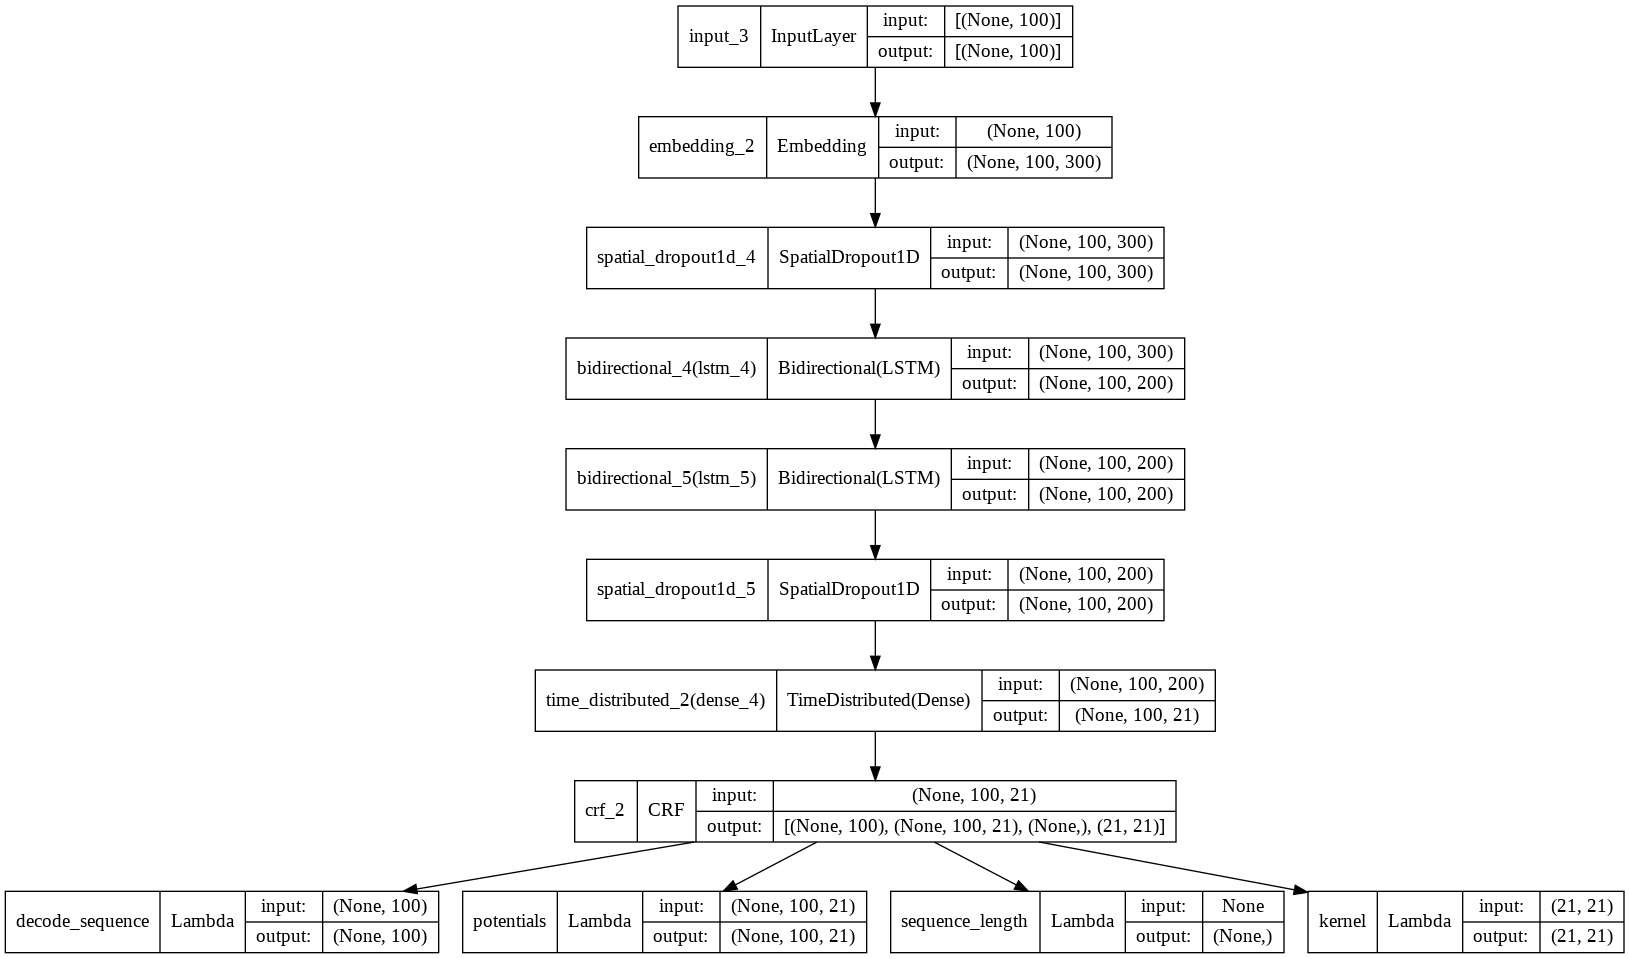

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 18s 300ms/step - decode_sequence_acc: 0.7607 - loss: 95.7017 - val_decode_sequence_acc: 0.7925 - val_loss: 56.0215
Epoch 2/30
30/30 [==============================] - 8s 275ms/step - decode_sequence_acc: 0.8039 - loss: 49.5411 - val_decode_sequence_acc: 0.7914 - val_loss: 41.6097
Epoch 3/30
30/30 [==============================] - 7s 234ms/step - decode_sequence_acc: 0.8456 - loss: 30.4929 - val_decode_sequence_acc: 0.8636 - val_loss: 26.2792
Epoch 4/30
30/30 [==============================] - 7s 227ms/step - decode_sequence_acc: 0.8661 - loss: 21.4087 - val_decode_sequence_acc: 0.8730 - val_loss: 19.8379
Epoch 5/30
30/30 [==============================] - 7s 225ms/step - decode_sequence_acc: 0.8802 - loss: 16.3211 - val_decode_sequence_acc: 0.8597 - val_loss: 17.5467
Epoch 6/30
30/30 [==============================] - 7s 224ms/step - decode_sequence_acc: 0.8847 - loss: 13.4880 - val_decode_sequence_acc: 0.8761 - val_loss: 16.6100
Epo

## Đánh giá mô hình

In [ ]:
print_report()

              precision    recall  f1-score   support

     BATTERY     0.6075    0.6516    0.6287       950
      CAMERA     0.6478    0.7011    0.6734       522
      DESIGN     0.5455    0.6052    0.5738       347
    FEATURES     0.4537    0.4971    0.4744       700
     GENERAL     0.5469    0.6125    0.5779      1427
 PERFORMANCE     0.4755    0.5575    0.5132      1182
       PRICE     0.3553    0.3600    0.3576       225
      SCREEN     0.5435    0.5411    0.5423       231
     SER&ACC     0.4802    0.5366    0.5068       451
     STORAGE     0.4400    0.3438    0.3860        32

   micro avg     0.5271    0.5827    0.5535      6067
   macro avg     0.5096    0.5407    0.5234      6067
weighted avg     0.5276    0.5827    0.5535      6067



In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	I-FEATURES
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn   

# Sử dụng pre-trained wiki.vi.vec

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/wiki.vi.vec')
for line in f:
    values = line.split(' ')[:-1]
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix3 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix3[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix3[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix3)
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     3812100     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 200)     320800      ['spatial_dropout1d[0][0]

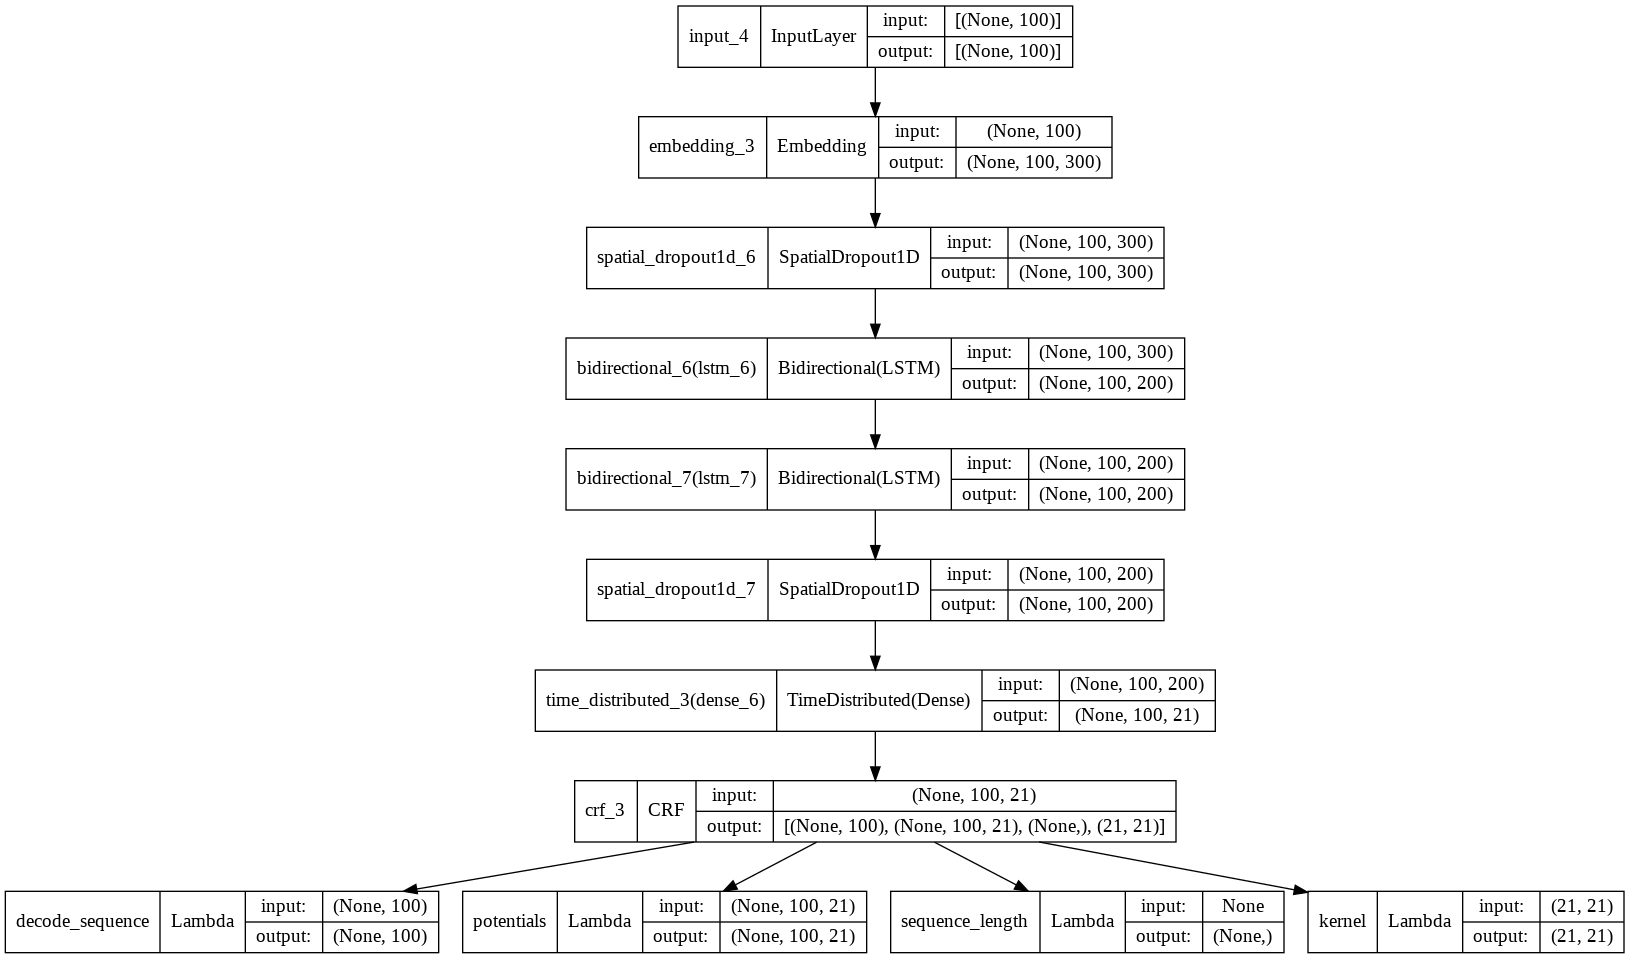

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 35s 634ms/step - decode_sequence_acc: 0.7448 - loss: 94.4470 - val_decode_sequence_acc: 0.7919 - val_loss: 57.0168
Epoch 2/30
30/30 [==============================] - 16s 531ms/step - decode_sequence_acc: 0.8056 - loss: 51.0932 - val_decode_sequence_acc: 0.8269 - val_loss: 39.7634
Epoch 3/30
30/30 [==============================] - 16s 531ms/step - decode_sequence_acc: 0.8507 - loss: 29.6052 - val_decode_sequence_acc: 0.8565 - val_loss: 24.8884
Epoch 4/30
30/30 [==============================] - 16s 529ms/step - decode_sequence_acc: 0.8672 - loss: 21.4386 - val_decode_sequence_acc: 0.8784 - val_loss: 19.2266
Epoch 5/30
30/30 [==============================] - 16s 540ms/step - decode_sequence_acc: 0.8771 - loss: 16.9823 - val_decode_sequence_acc: 0.8734 - val_loss: 17.2264
Epoch 6/30
30/30 [==============================] - 16s 537ms/step - decode_sequence_acc: 0.8798 - loss: 14.2536 - val_decode_sequence_acc: 0.8806 - val_loss: 17.704

## Đánh giá mô hình

In [ ]:
print_report()

              precision    recall  f1-score   support

     BATTERY     0.6190    0.6600    0.6388       950
      CAMERA     0.6840    0.7050    0.6943       522
      DESIGN     0.5567    0.6081    0.5813       347
    FEATURES     0.4861    0.5257    0.5051       700
     GENERAL     0.5735    0.6125    0.5923      1427
 PERFORMANCE     0.5132    0.5745    0.5421      1182
       PRICE     0.3695    0.3333    0.3505       225
      SCREEN     0.5391    0.5974    0.5667       231
     SER&ACC     0.4801    0.5344    0.5058       451
     STORAGE     0.3793    0.3438    0.3607        32

   micro avg     0.5506    0.5921    0.5706      6067
   macro avg     0.5200    0.5495    0.5338      6067
weighted avg     0.5505    0.5921    0.5703      6067



In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	I-FEATURES
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn   

# Kết hợp với char-LSTM

## Char encode

In [ ]:
max_len_char = 15
chars = set([c for w in words for c in w])
n_chars = len(chars) + 2

In [ ]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [ ]:
def char_encode(data):
  X_char = []
  sent_idx = 0
  for sentence in data:
      sent_seq = []
      for i in range(max_len):
          word_seq = []
          for j in range(max_len_char):
              try:
                  word_seq.append(char2idx.get(data[sent_idx][i][j], char2idx.get('UNK')))
              except:
                  word_seq.append(char2idx.get('PAD'))
          sent_seq.append(word_seq)
      X_char.append(np.array(sent_seq))
      sent_idx += 1
  return X_char

In [ ]:
x_char_train = char_encode(train_set[0])
x_char_dev = char_encode(dev_set[0])
x_char_test = char_encode(test_set[0])

In [ ]:
x_char_train = np.array(x_char_train).reshape((len(x_char_train), max_len, max_len_char))
x_char_dev = np.array(x_char_dev).reshape((len(x_char_dev), max_len, max_len_char))
x_char_test = np.array(x_char_test).reshape((len(x_char_test), max_len, max_len_char))

## Không sử dụng pre-trained embedding

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
# syllabel embedding
input_word = Input(shape=(max_len,), dtype="float64")
syl_emb = Embedding(input_dim=num_words, output_dim=100,
                    input_length=max_len)(input_word)

# character embedding
input_char = Input(shape=(max_len, max_len_char,), dtype="float64")
char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=embedding_dim,
                           input_length=max_len_char))(input_char)
char_emb = Dropout(0.33)(char_emb)
char_emb = TimeDistributed(LSTM(units=100, return_sequences=False, dropout=0.33))(char_emb)
char_emb = SpatialDropout1D(0.33)(char_emb)
char_emb = TimeDistributed(Dense(100, activation="relu"))(char_emb)

# Concatenate
emb = Concatenate()([syl_emb, char_emb])

# model
model = SpatialDropout1D(0.33)(emb)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
model = SpatialDropout1D(0.33)(model)
out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
model = Model([input_word, input_char], out)
model = CRFModel(model, num_tags)

# setting and summary
opt = optimizers.Nadam(2e-2)
model.compile(optimizer=opt, metrics=['acc'])

In [ ]:
model.summary()

Model: "crf_model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 100, 15, 300  102000     ['input_6[0][0]']                
 buted)                         )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 100, 15, 300  0           ['time_distributed_4[0][0]']     
                                )                                                                 
                                                                                        

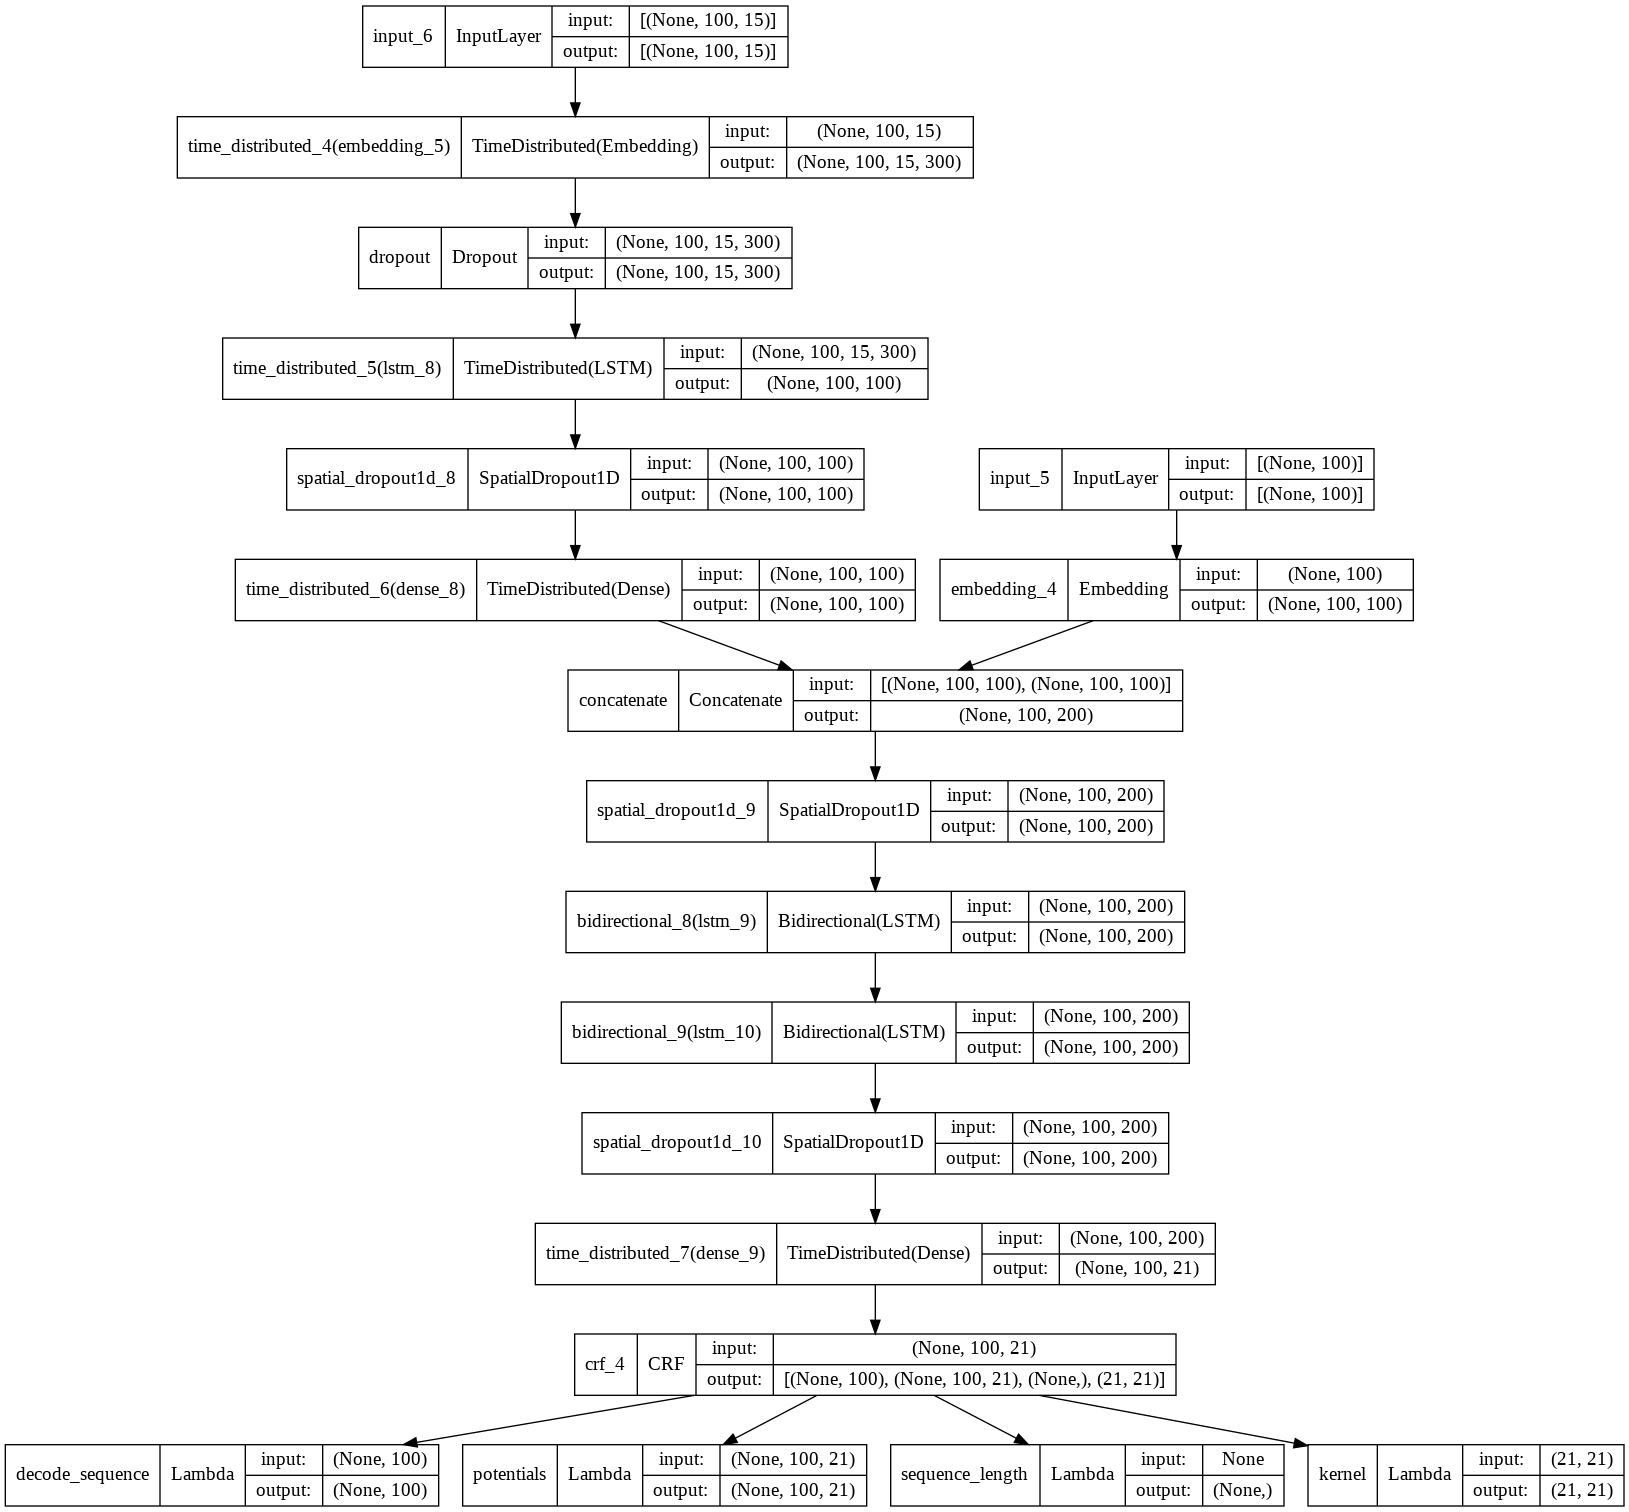

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 26s 492ms/step - decode_sequence_acc: 0.7079 - loss: 109.4931 - val_decode_sequence_acc: 0.7918 - val_loss: 50.2677
Epoch 2/30
30/30 [==============================] - 13s 423ms/step - decode_sequence_acc: 0.7918 - loss: 44.5922 - val_decode_sequence_acc: 0.7923 - val_loss: 33.4372
Epoch 3/30
30/30 [==============================] - 13s 423ms/step - decode_sequence_acc: 0.8099 - loss: 26.7981 - val_decode_sequence_acc: 0.8438 - val_loss: 21.8297
Epoch 4/30
30/30 [==============================] - 13s 424ms/step - decode_sequence_acc: 0.8244 - loss: 18.0492 - val_decode_sequence_acc: 0.8268 - val_loss: 16.6224
Epoch 5/30
30/30 [==============================] - 13s 429ms/step - decode_sequence_acc: 0.8315 - loss: 14.2648 - val_decode_sequence_acc: 0.8328 - val_loss: 13.1146
Epoch 6/30
30/30 [==============================] - 13s 426ms/step - decode_sequence_acc: 0.8365 - loss: 11.5008 - val_decode_sequence_acc: 0.8236 - val_loss: 13.20

### Đánh giá mô hình

In [ ]:
def cprint_report():
  y_tr = y_test
  y_pr = model.predict([x_test, x_char_test.astype(np.float)])[0]

  Y_tr = []
  Y_pr = []

  for i, j in zip(range(len(y_tr)), range(len(y_pr))):
    true = []
    pred = []
    for k in range(len(y_tr[i])):
      true.append(tags[y_tr[i][k]])
      pred.append(tags[y_pr[j][k]])
    Y_tr.append(true)
    Y_pr.append(pred)

  print(classification_report(Y_tr, Y_pr, digits =4,))

In [ ]:
cprint_report()

              precision    recall  f1-score   support

     BATTERY     0.6251    0.6811    0.6519       950
      CAMERA     0.6543    0.7433    0.6960       522
      DESIGN     0.5100    0.5879    0.5462       347
    FEATURES     0.5062    0.5243    0.5151       700
     GENERAL     0.5785    0.6195    0.5983      1427
 PERFORMANCE     0.5255    0.5753    0.5493      1182
       PRICE     0.3510    0.3822    0.3660       225
      SCREEN     0.5164    0.6147    0.5613       231
     SER&ACC     0.4990    0.5610    0.5282       451
     STORAGE     0.4583    0.3438    0.3929        32

   micro avg     0.5527    0.6036    0.5770      6067
   macro avg     0.5224    0.5633    0.5405      6067
weighted avg     0.5524    0.6036    0.5766      6067



In [ ]:
def cpredict(i):
  y_pr = model.predict([x_test, x_char_test.astype(np.float)])[0]
  y_pred = y_pr[i]
  y_true = y_test[i]
  print("{:20}{:20}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(x_test[i], y_true, y_pred):
      print("{:20}{:20}\t{}".format(words[w], tags[true], tags[pred]))

In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-DESIGN
thấy                B-DESIGN            	I-DESIGN
mẫu                 I-DESIGN            	I-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	I-FEATURES
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-

## Sử dụng pre-trained PhoW2V

### Xây dựng và huấn luyện mô hình

In [ ]:
# syllabel embedding
def cmodel_BiLSTM_CRF(embedding_matrix):
  input_word = Input(shape=(max_len,), dtype="float64")
  syl_emb = Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant([embedding_matrix]),
                      input_length=max_len, trainable=True)(input_word)

  # character embedding
  input_char = Input(shape=(max_len, max_len_char,), dtype="float64")
  char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=embedding_dim,
                            input_length=max_len_char))(input_char)
  char_emb = Dropout(0.33)(char_emb)
  char_emb = TimeDistributed(LSTM(units=100, return_sequences=False, dropout=0.33))(char_emb)
  char_emb = SpatialDropout1D(0.33)(char_emb)
  char_emb = TimeDistributed(Dense(100, activation="relu"))(char_emb)

  # Concatenate
  emb = Concatenate()([syl_emb, char_emb])

  # model
  model = SpatialDropout1D(0.33)(emb)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = SpatialDropout1D(0.33)(model)
  out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
  model = Model([input_word, input_char], out)
  model = CRFModel(model, num_tags)

  # setting and summary
  opt = optimizers.Nadam(2e-2)
  model.compile(optimizer=opt, metrics=['acc'])
  return model

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix1)
model.summary()

Model: "crf_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_8 (TimeDistri  (None, 100, 15, 300  102000     ['input_8[0][0]']                
 buted)                         )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_8[0][0]']     
                                )                                                                 
                                                                                        

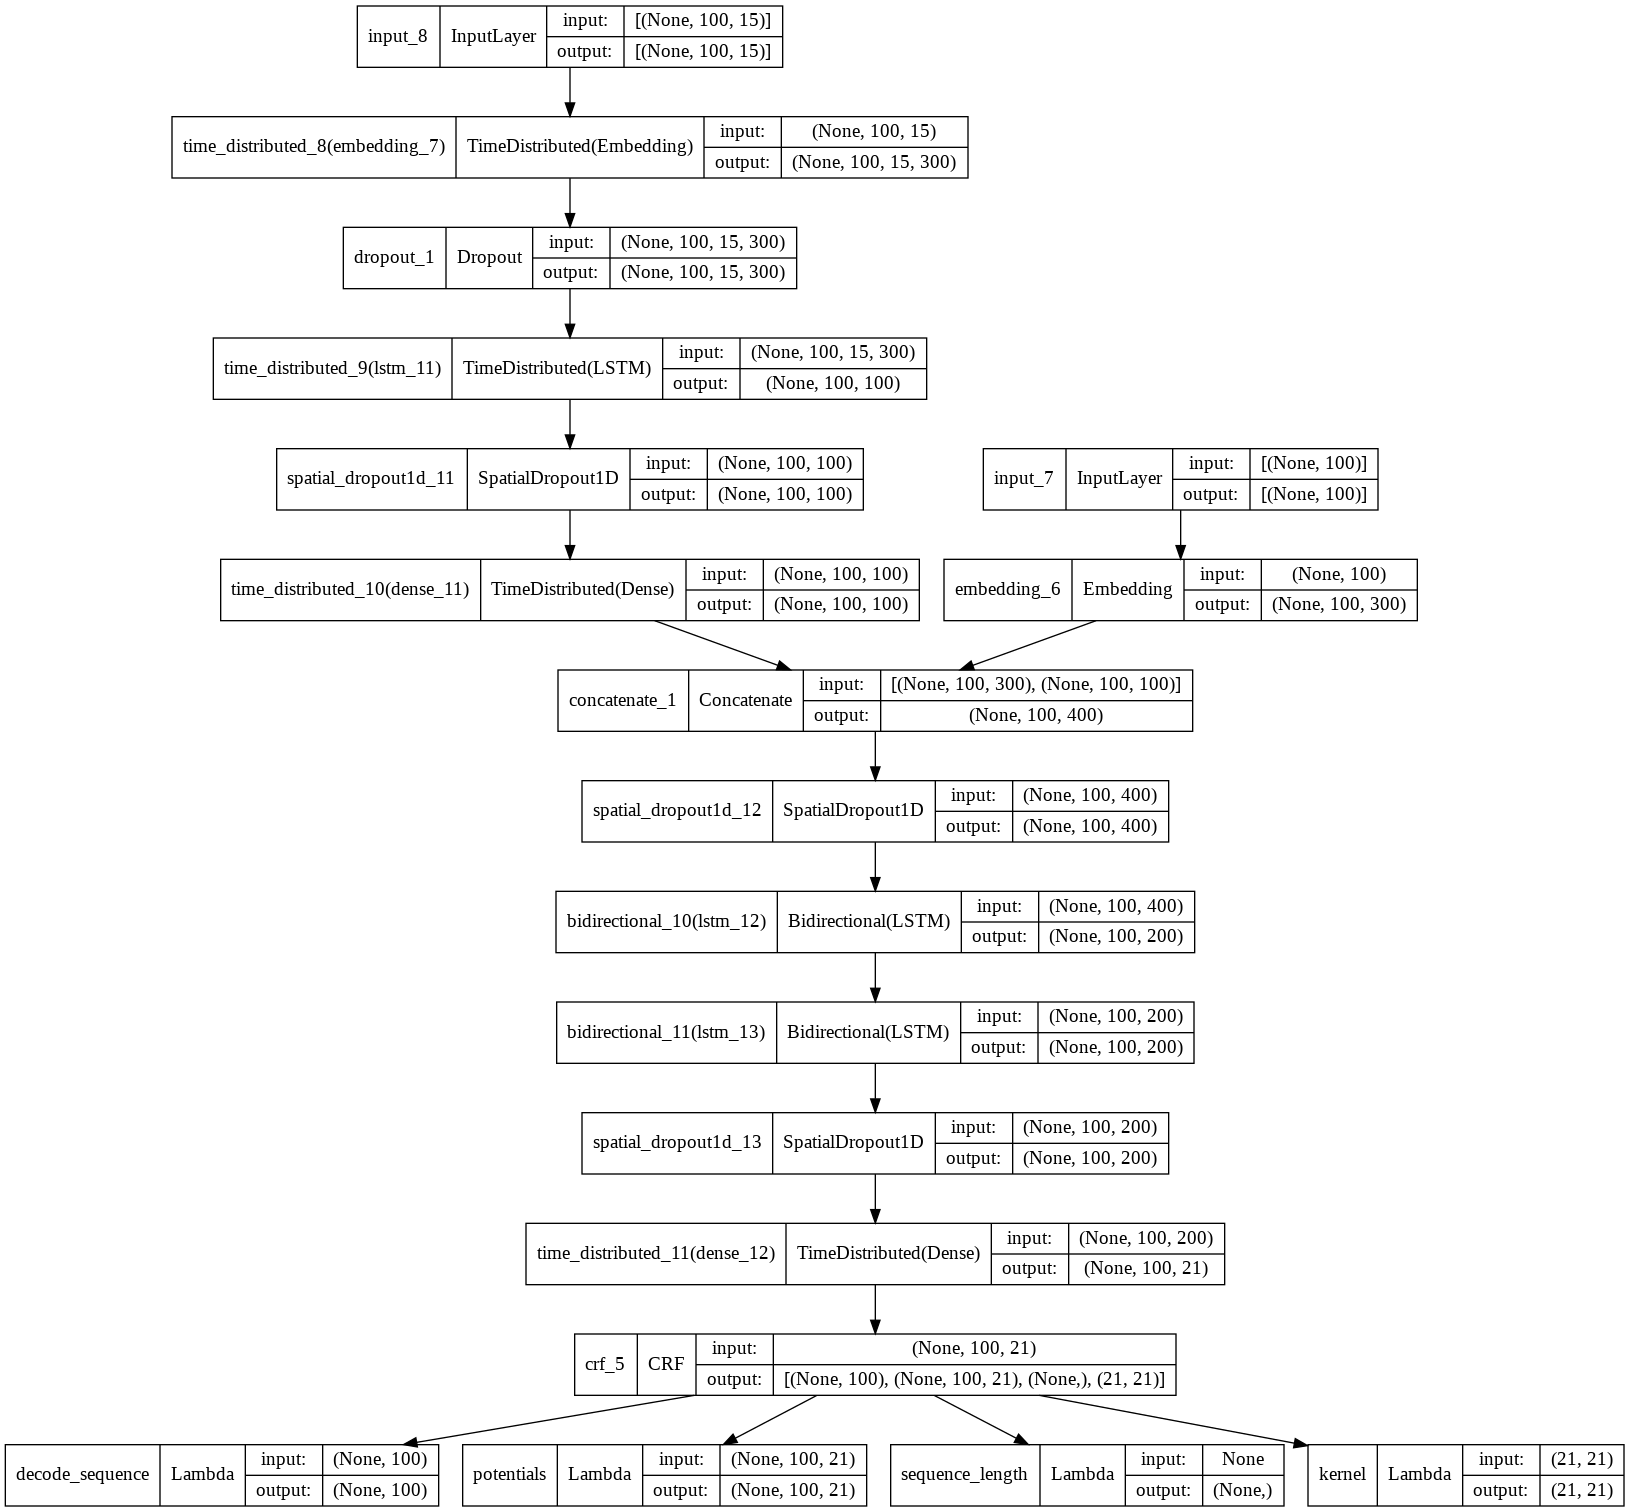

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 26s 505ms/step - decode_sequence_acc: 0.7357 - loss: 123.3795 - val_decode_sequence_acc: 0.7918 - val_loss: 76.4620
Epoch 2/30
30/30 [==============================] - 13s 427ms/step - decode_sequence_acc: 0.7888 - loss: 72.2131 - val_decode_sequence_acc: 0.7918 - val_loss: 62.6934
Epoch 3/30
30/30 [==============================] - 13s 426ms/step - decode_sequence_acc: 0.7888 - loss: 54.8607 - val_decode_sequence_acc: 0.7918 - val_loss: 58.0466
Epoch 4/30
30/30 [==============================] - 13s 433ms/step - decode_sequence_acc: 0.7886 - loss: 62.0299 - val_decode_sequence_acc: 0.7918 - val_loss: 35.2363
Epoch 5/30
30/30 [==============================] - 13s 427ms/step - decode_sequence_acc: 0.7886 - loss: 34.8900 - val_decode_sequence_acc: 0.7918 - val_loss: 28.3798
Epoch 6/30
30/30 [==============================] - 13s 432ms/step - decode_sequence_acc: 0.7888 - loss: 28.8936 - val_decode_sequence_acc: 0.7928 - val_loss: 23.15

### Đánh giá mô hình

In [ ]:
cprint_report()

              precision    recall  f1-score   support

     BATTERY     0.6485    0.6526    0.6506       950
      CAMERA     0.6278    0.6916    0.6582       522
      DESIGN     0.5894    0.6081    0.5986       347
    FEATURES     0.5394    0.4886    0.5127       700
     GENERAL     0.5904    0.6041    0.5972      1427
 PERFORMANCE     0.5207    0.5423    0.5313      1182
       PRICE     0.3767    0.3600    0.3682       225
      SCREEN     0.5375    0.5584    0.5478       231
     SER&ACC     0.5340    0.5055    0.5194       451
     STORAGE     0.4800    0.3750    0.4211        32

   micro avg     0.5697    0.5747    0.5722      6067
   macro avg     0.5445    0.5386    0.5405      6067
weighted avg     0.5685    0.5747    0.5712      6067



In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	O
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn            

## Sử dụng pre-trained cc.vi.300.vec

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix2)
model.summary()

Model: "crf_model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_12 (TimeDistr  (None, 100, 15, 300  102000     ['input_10[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_2 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_12[0][0]']    
                                )                                                                 
                                                                                        

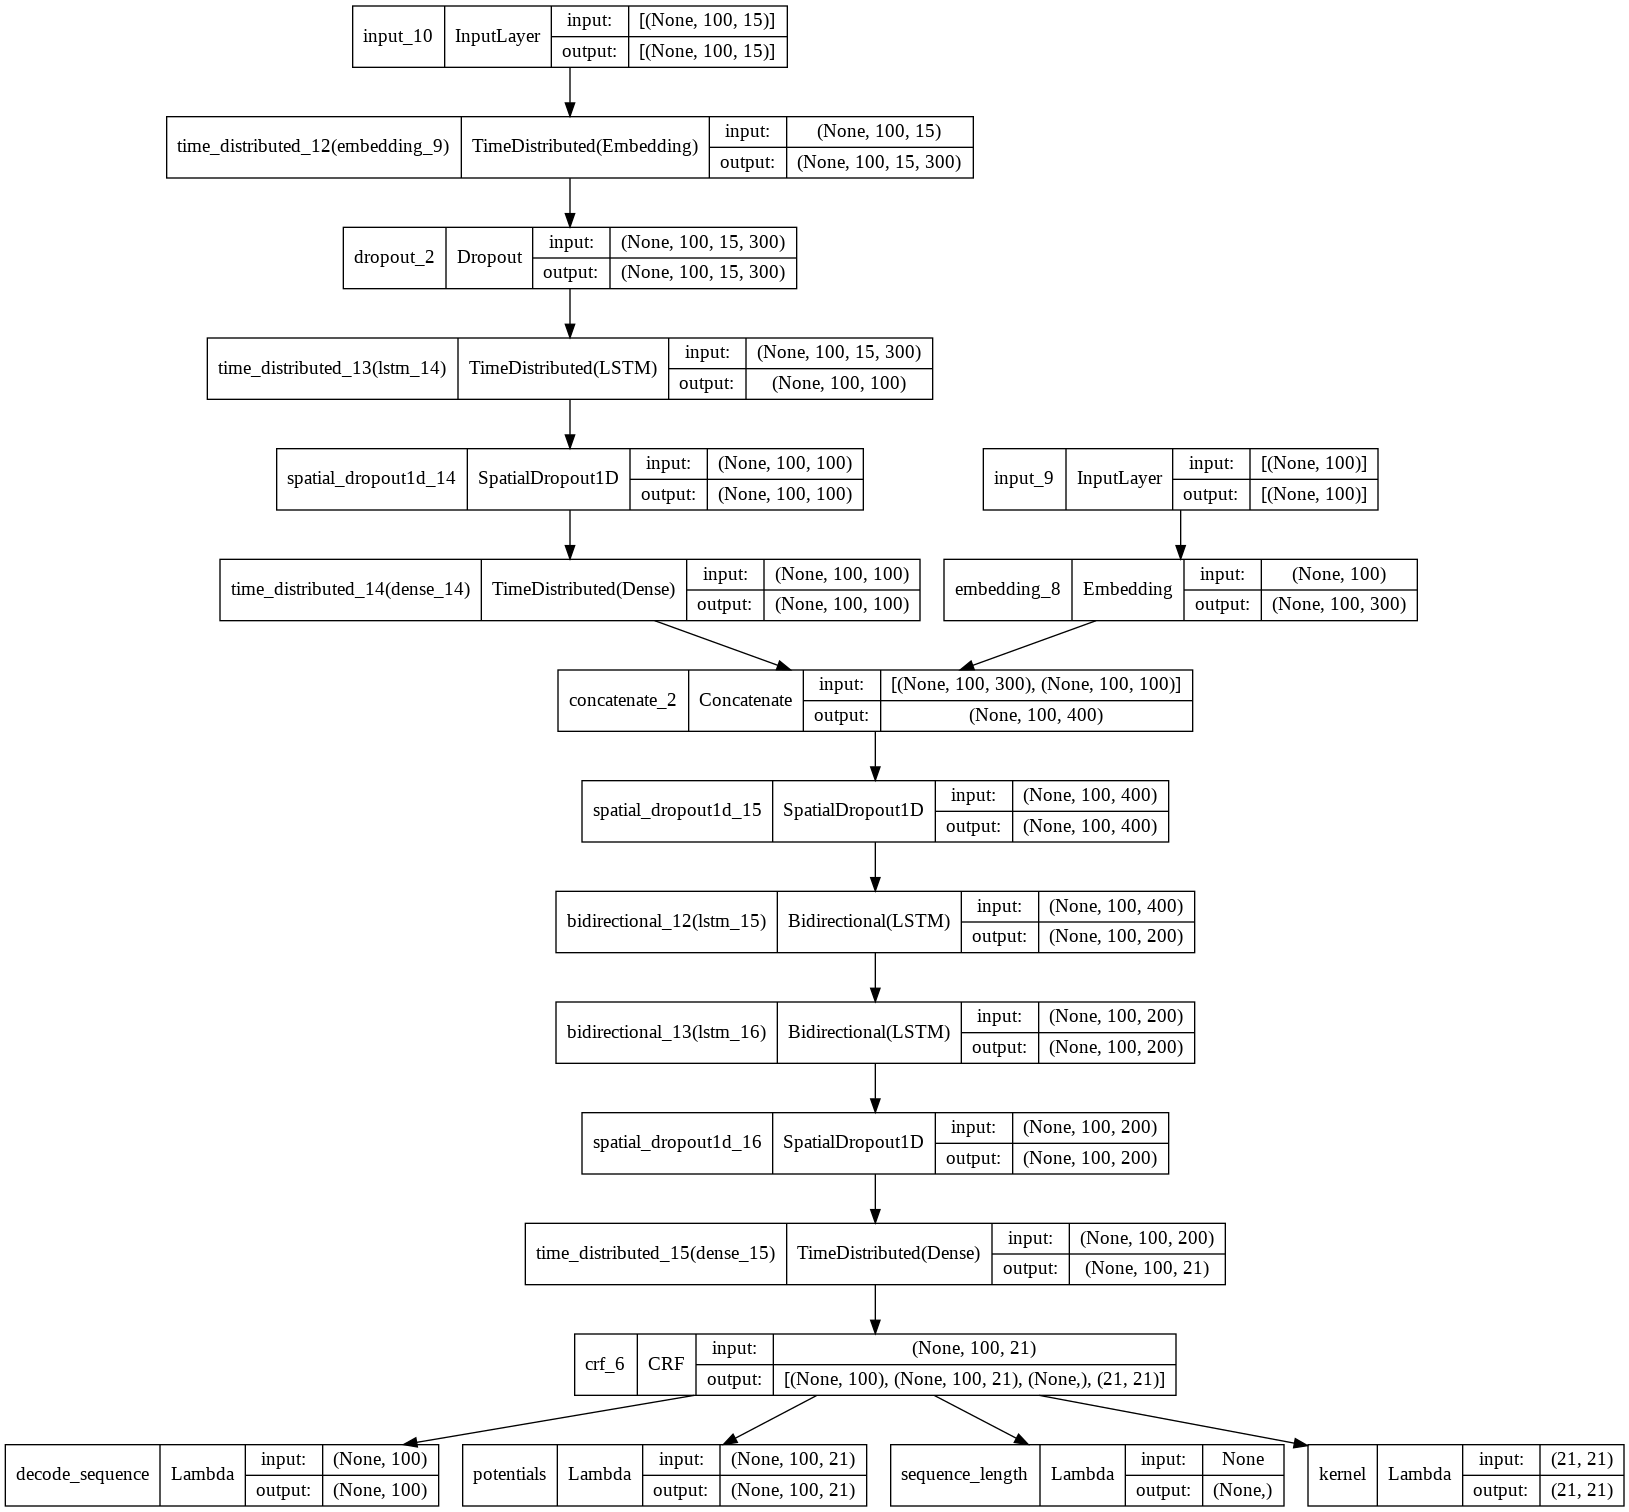

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 25s 490ms/step - decode_sequence_acc: 0.7351 - loss: 122.4323 - val_decode_sequence_acc: 0.7918 - val_loss: 73.7209
Epoch 2/30
30/30 [==============================] - 13s 426ms/step - decode_sequence_acc: 0.7888 - loss: 59.2788 - val_decode_sequence_acc: 0.7918 - val_loss: 39.3372
Epoch 3/30
30/30 [==============================] - 12s 417ms/step - decode_sequence_acc: 0.7891 - loss: 36.3628 - val_decode_sequence_acc: 0.7937 - val_loss: 28.5231
Epoch 4/30
30/30 [==============================] - 13s 425ms/step - decode_sequence_acc: 0.7929 - loss: 25.7452 - val_decode_sequence_acc: 0.7998 - val_loss: 20.8694
Epoch 5/30
30/30 [==============================] - 13s 430ms/step - decode_sequence_acc: 0.8058 - loss: 18.4213 - val_decode_sequence_acc: 0.8403 - val_loss: 16.9997
Epoch 6/30
30/30 [==============================] - 13s 429ms/step - decode_sequence_acc: 0.8254 - loss: 13.0824 - val_decode_sequence_acc: 0.8403 - val_loss: 13.07

### Đánh giá mô hình

In [ ]:
cprint_report()

              precision    recall  f1-score   support

     BATTERY     0.5988    0.6347    0.6162       950
      CAMERA     0.6003    0.6935    0.6436       522
      DESIGN     0.6006    0.5937    0.5971       347
    FEATURES     0.4859    0.4929    0.4894       700
     GENERAL     0.5415    0.5851    0.5625      1427
 PERFORMANCE     0.5104    0.5406    0.5251      1182
       PRICE     0.3796    0.3644    0.3719       225
      SCREEN     0.5498    0.5498    0.5498       231
     SER&ACC     0.4449    0.5188    0.4790       451
     STORAGE     0.4231    0.3438    0.3793        32

   micro avg     0.5335    0.5677    0.5500      6067
   macro avg     0.5135    0.5317    0.5214      6067
weighted avg     0.5329    0.5677    0.5494      6067



In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	I-FEATURES
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn   

## Sử dụng pre-trained wiki.vi.vec

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix3)
model.summary()

Model: "crf_model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_16 (TimeDistr  (None, 100, 15, 300  102000     ['input_12[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_3 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_16[0][0]']    
                                )                                                                 
                                                                                        

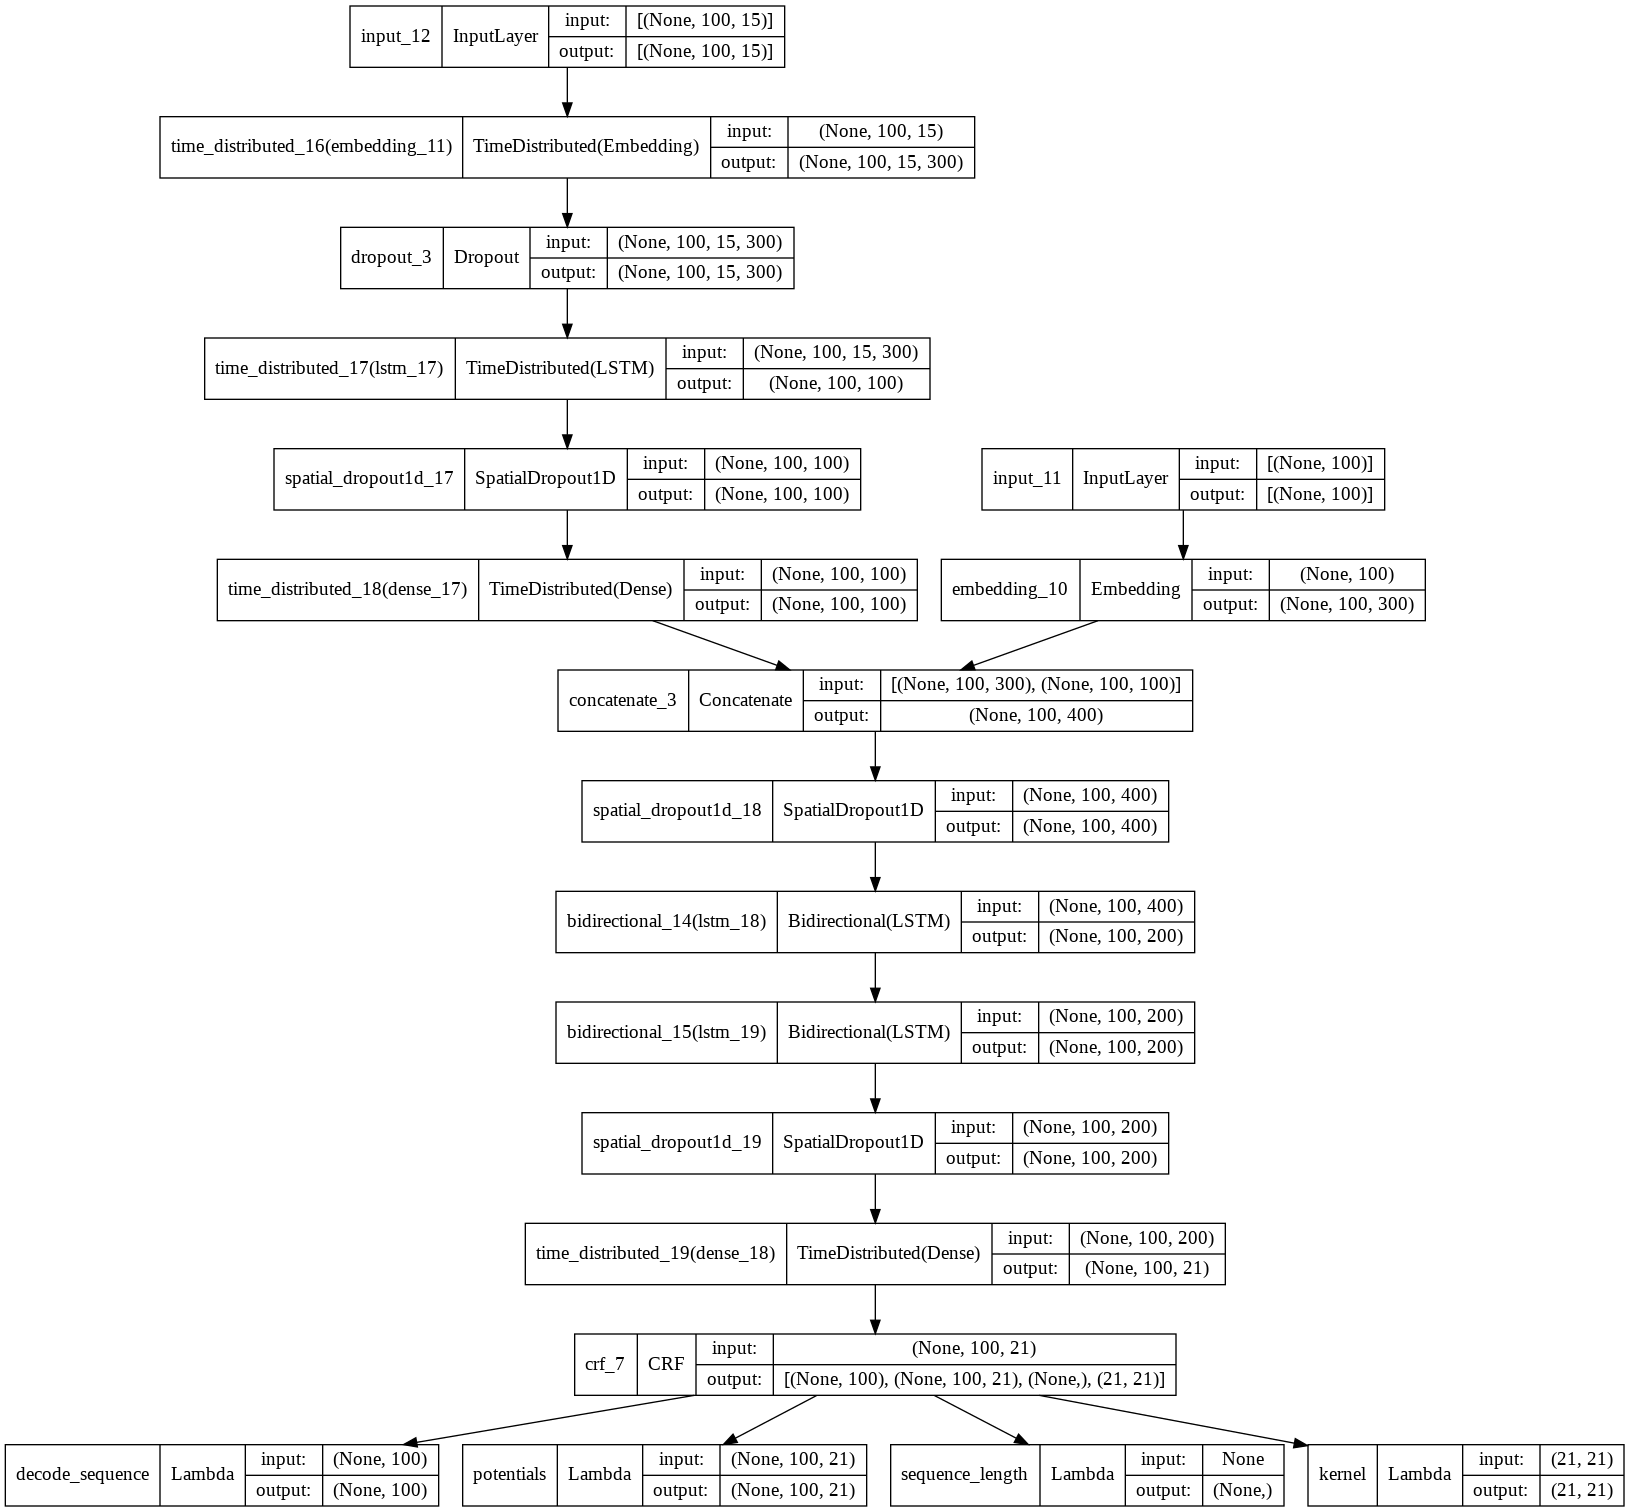

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
30/30 [==============================] - 26s 511ms/step - decode_sequence_acc: 0.7387 - loss: 108.4350 - val_decode_sequence_acc: 0.7918 - val_loss: 61.8515
Epoch 2/30
30/30 [==============================] - 13s 442ms/step - decode_sequence_acc: 0.7873 - loss: 52.4179 - val_decode_sequence_acc: 0.7977 - val_loss: 34.5106
Epoch 3/30
30/30 [==============================] - 13s 436ms/step - decode_sequence_acc: 0.8017 - loss: 29.5118 - val_decode_sequence_acc: 0.8196 - val_loss: 21.0446
Epoch 4/30
30/30 [==============================] - 13s 438ms/step - decode_sequence_acc: 0.8312 - loss: 18.2531 - val_decode_sequence_acc: 0.8414 - val_loss: 14.5175
Epoch 5/30
30/30 [==============================] - 13s 435ms/step - decode_sequence_acc: 0.8439 - loss: 13.4143 - val_decode_sequence_acc: 0.8418 - val_loss: 12.5747
Epoch 6/30
30/30 [==============================] - 13s 433ms/step - decode_sequence_acc: 0.8457 - loss: 10.5426 - val_decode_sequence_acc: 0.8310 - val_loss: 10.95

### Đánh giá mô hình

In [ ]:
cprint_report()

              precision    recall  f1-score   support

     BATTERY     0.6363    0.6758    0.6554       950
      CAMERA     0.7043    0.7165    0.7104       522
      DESIGN     0.5826    0.5994    0.5909       347
    FEATURES     0.4904    0.5100    0.5000       700
     GENERAL     0.6062    0.6062    0.6062      1427
 PERFORMANCE     0.5290    0.5398    0.5343      1182
       PRICE     0.3593    0.3689    0.3640       225
      SCREEN     0.5726    0.5974    0.5847       231
     SER&ACC     0.5376    0.5078    0.5222       451
     STORAGE     0.3704    0.3125    0.3390        32

   micro avg     0.5732    0.5841    0.5786      6067
   macro avg     0.5389    0.5434    0.5407      6067
weighted avg     0.5728    0.5841    0.5783      6067



# Chạy predict trên mô hình chỉ sử dụng pre-trained wiki.vi.vec

In [ ]:
predict(1)

Word                True                	 Pred

------------------------------
Mua                 O                   	O
cho                 O                   	O
mẹ                  O                   	O
sài                 O                   	O
nên                 O                   	O
củng                O                   	O
không               O                   	O
đòi                 O                   	O
hỏi                 O                   	O
gì                  O                   	O
nhiều               O                   	O
,                   O                   	O
máy                 B-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
camera              O                   	B-CAMERA
siêu                O                   	I-CAMERA
ảo                  O                   	I-CAMERA
,                   O                   	O
thử                 B-PERFORMANCE       	O
chiến               I-PERFORMANCE       	B-PERFORMANCE
game          

In [ ]:
predict(2)

Word                True                	 Pred

------------------------------
Máy                 B-GENERAL           	B-GENERAL
xài                 I-GENERAL           	I-GENERAL
tốt                 I-GENERAL           	I-GENERAL
,                   O                   	O
mượt                B-PERFORMANCE       	B-PERFORMANCE
,                   O                   	O
sạc                 B-BATTERY           	B-BATTERY
rất                 I-BATTERY           	I-BATTERY
nhanh               I-BATTERY           	I-BATTERY
,                   O                   	I-BATTERY
pin                 B-BATTERY           	I-BATTERY
trâu                I-BATTERY           	I-BATTERY
,                   O                   	I-BATTERY
mình                O                   	I-BATTERY
dùng                O                   	I-BATTERY
tác                 O                   	I-BATTERY
vụ                  O                   	I-BATTERY
bình                O                   	I-BATTERY
thường         

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN            	O
mẫu                 I-DESIGN            	B-DESIGN
đẹp                 I-DESIGN            	I-DESIGN
pin                 B-BATTERY           	B-BATTERY
trâu                I-BATTERY           	I-BATTERY
cảm                 B-FEATURES          	B-FEATURES
ứng                 I-FEATURES          	I-FEATURES
mượt                I-FEATURES          	I-FEATURES
được                B-SER&ACC           	I-FEATURES
em                  I-SER&ACC           	O
nhân                I-SER&ACC           	B-SER&ACC
viên                I-SER&ACC           	I-SER&ACC
ĐMX                 I-SER&ACC           	I-SER&ACC
tư                  I-SER&ACC           	I-SER&ACC
vấn   